# 3D spatial transcriptomics Interpolation

This notebook demonstrates the process of continuous expression pattern learning in the 3D volume model. Spateo contains the following four interpolation methods:

1. The methods (Shepard, Gaussian and Linear) contained in the VTK;
2. A new Gaussian Process method;
3. The SparseVFC method contained in the Dynamo;
4. A new Deep Learning method.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import spateo as st
import dynamo as dyn

2023-07-25 10:56:52.023987: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Load the data


In [2]:
cpo = [(553, 1098, 277), (1.967, -6.90, -2.21), (0, 0, 1)]

# adata = st.sample_data.drosophila(filename="E7-9h_cellbin_tdr_v2.h5ad")
adata = st.read_h5ad("E7-9h_cellbin.h5ad")
adata.uns["pp"] = {}
adata.uns["__type"] = "UMI"
dyn.pp.normalize(adata)
dyn.pp.log1p(adata)
adata

AnnData object with n_obs × n_vars = 25921 × 8136
    obs: 'area', 'slices', 'anno_cell_type', 'anno_tissue', 'anno_germ_layer', 'actual_stage', 'Size_Factor', 'initial_cell_size', 'counts_X_Size_Factor', 'initial_counts_X_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size'
    uns: 'pp', '__type'
    obsm: '3d_align_spatial'
    layers: 'counts_X', 'spliced', 'unspliced', 'X_counts_X', 'X_unspliced', 'X_spliced'

## Reconstruct the models corresponding to the 3D spatial transcriptomics data

See also [3D Reconstruction](./3D%20Reconstruction.ipynb) for more details on 3D reconstructed models.

In [12]:
# Reconstruct point cloud model
pc, plot_cmap = st.tdr.construct_pc(adata=adata.copy(), spatial_key="3d_align_spatial", groupby="anno_tissue")

# Reconstruct mesh model
mesh, _, _ = st.tdr.construct_surface(pc=pc, alpha=0.6, cs_method="marching_cube", cs_args={"mc_scale_factor": 0.8}, smooth=5000, scale_factor=1.08)

# Reconstruct voxel model
voxel, _ = st.tdr.voxelize_mesh(mesh=mesh, voxel_pc=pc, smooth=10)
voxel

UnstructuredGrid,Information
N Cells,44751
N Points,47752
X Bounds,"-2.736e+02, 2.793e+02"
Y Bounds,"-1.137e+02, 1.003e+02"
Z Bounds,"-9.462e+01, 9.264e+01"
N Arrays,0


The

## The raw gene expression patterns in the point cloud model



In [41]:
genes = ["Bacc", "HmgD", "Ance"]

# Add gene expression matrix to the point cloud model
pc_index=pc.point_data["obs_index"].tolist()
for gene_name in genes:
    exp = adata[pc_index, gene_name].X.flatten()
    st.tdr.add_model_labels(model=pc, labels=exp, key_added=gene_name, where="point_data",inplace=True)

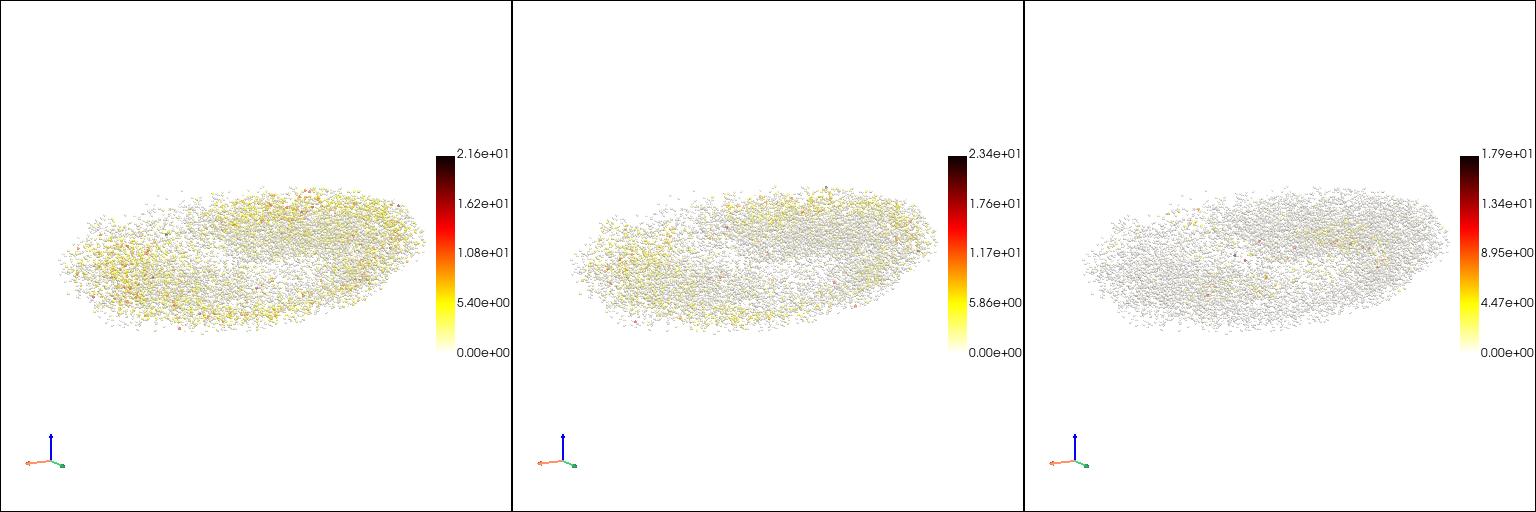

In [42]:
st.pl.three_d_multi_plot(
    model=pc,
    key=genes,
    colormap="hot_r",
    opacity=0.5,
    model_style="points",
    jupyter="static",
    cpo=[cpo]
)

## Learn a continuous mapping from space to gene expression pattern with the method contained in VTK

In [43]:
interpolated_vtk_adata = st.tdr.vtk_interpolation(source_adata=adata.copy(), spatial_key="3d_align_spatial", keys=genes, target_points=np.asarray(voxel.points), n_points=5)
interpolated_vtk_adata

|-----> Creating an adata object with the interpolated expression...
|-----> [VTKInterpolation] in progress: 100.0000%
|-----> [VTKInterpolation] finished [104.8258s]


AnnData object with n_obs × n_vars = 18780 × 3
    obsm: '3d_align_spatial'

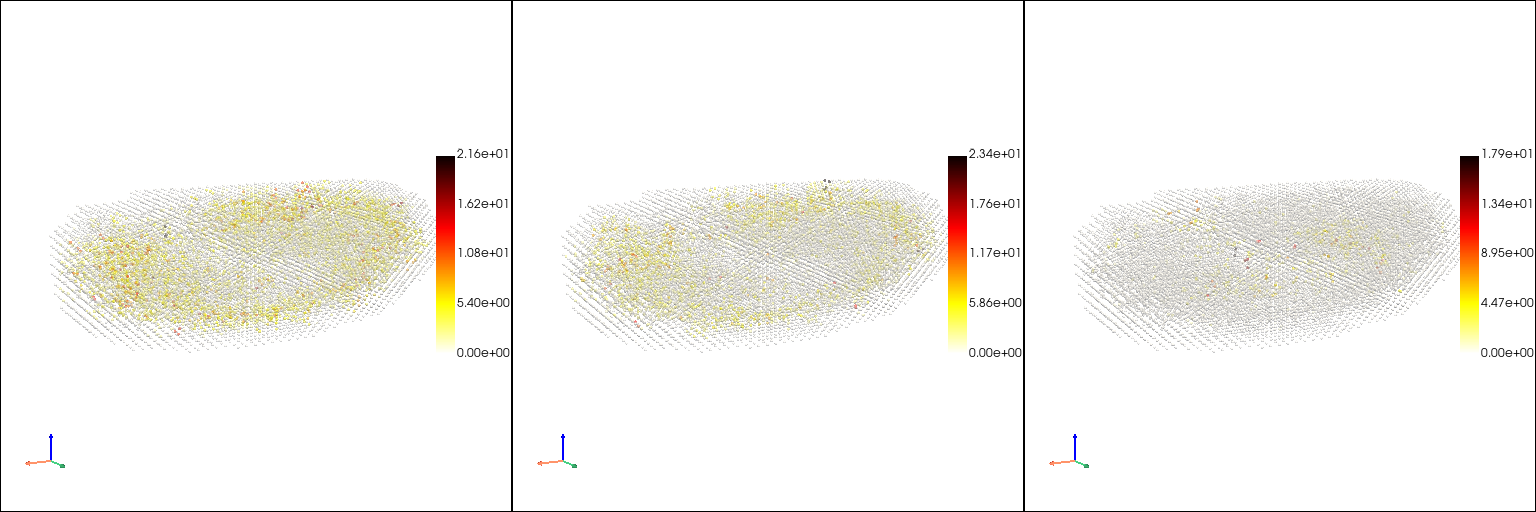

In [44]:
interpolated_vtk_pc, _ = st.tdr.construct_pc(adata=interpolated_vtk_adata.copy(), spatial_key="3d_align_spatial", groupby=genes[0])
_pc_index=interpolated_vtk_pc.point_data["obs_index"].tolist()
for gene_name in genes[1:]:
    _exp = interpolated_vtk_adata[_pc_index, gene_name].X.flatten()
    st.tdr.add_model_labels(model=interpolated_vtk_pc, labels=_exp, key_added=gene_name, where="point_data",inplace=True)

st.pl.three_d_multi_plot(
    model=interpolated_vtk_pc,
    key=genes,
    colormap="hot_r",
    opacity=0.5,
    model_style="points",
    jupyter="static",
    cpo=[cpo]
)

 ## Learn a continuous mapping from space to gene expression pattern with the Gaussian Process method


In [46]:
interpolated_gp_adata = st.tdr.gp_interpolation(source_adata=adata.copy(), spatial_key="3d_align_spatial", keys=genes, target_points=np.asarray(voxel.points), device="cpu")
interpolated_gp_adata

|-----> [Gaussian Process Regression] in progress: 100.0000%
|-----> [Gaussian Process Regression] finished [174.4697s]
|-----> Creating an adata object with the interpolated expression...
|-----> [GaussianProcessInterpolation] in progress: 100.0000%
|-----> [GaussianProcessInterpolation] finished [214.4344s]


AnnData object with n_obs × n_vars = 18780 × 3
    obsm: '3d_align_spatial'

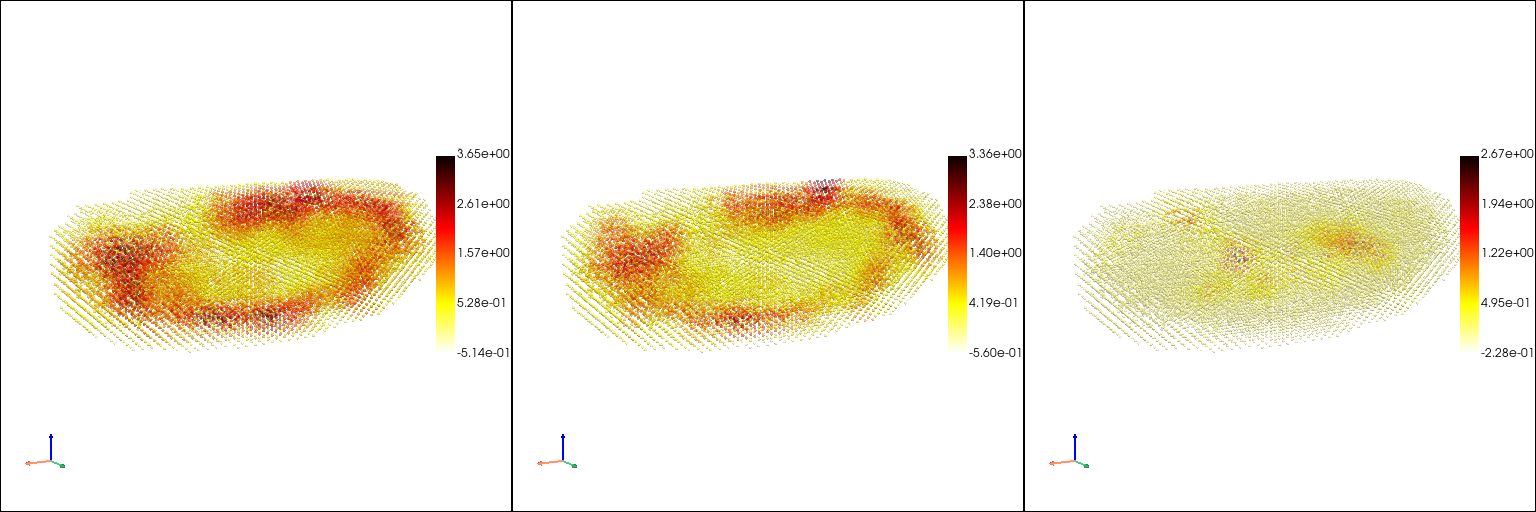

In [47]:
interpolated_gp_pc, _ = st.tdr.construct_pc(adata=interpolated_gp_adata.copy(), spatial_key="3d_align_spatial", groupby=genes[0])
_pc_index=interpolated_gp_pc.point_data["obs_index"].tolist()
for gene_name in genes[1:]:
    _exp = interpolated_gp_adata[_pc_index, gene_name].X.flatten()
    st.tdr.add_model_labels(model=interpolated_gp_pc, labels=_exp, key_added=gene_name, where="point_data",inplace=True)

st.pl.three_d_multi_plot(
    model=interpolated_gp_pc,
    key=genes,
    colormap="hot_r",
    opacity=0.5,
    model_style="points",
    jupyter="static",
    cpo=[cpo]
)

## Learn a continuous mapping from space to gene expression pattern with sparseVFC method

In [48]:
interpolated_svfc_adata = st.tdr.kernel_interpolation(source_adata=adata.copy(), spatial_key="3d_align_spatial", keys=genes, target_points=np.asarray(voxel.points))
interpolated_svfc_adata

|-----> [SparseVFC] begins...
|-----> Sampling control points based on data velocity magnitude...
|-----> [SparseVFC] completed [0.2289s]
|-----> Creating an adata object with the interpolated expression...
|-----> [KernelInterpolation] in progress: 100.0000%
|-----> [KernelInterpolation] finished [0.9643s]


AnnData object with n_obs × n_vars = 18780 × 3
    obsm: '3d_align_spatial'

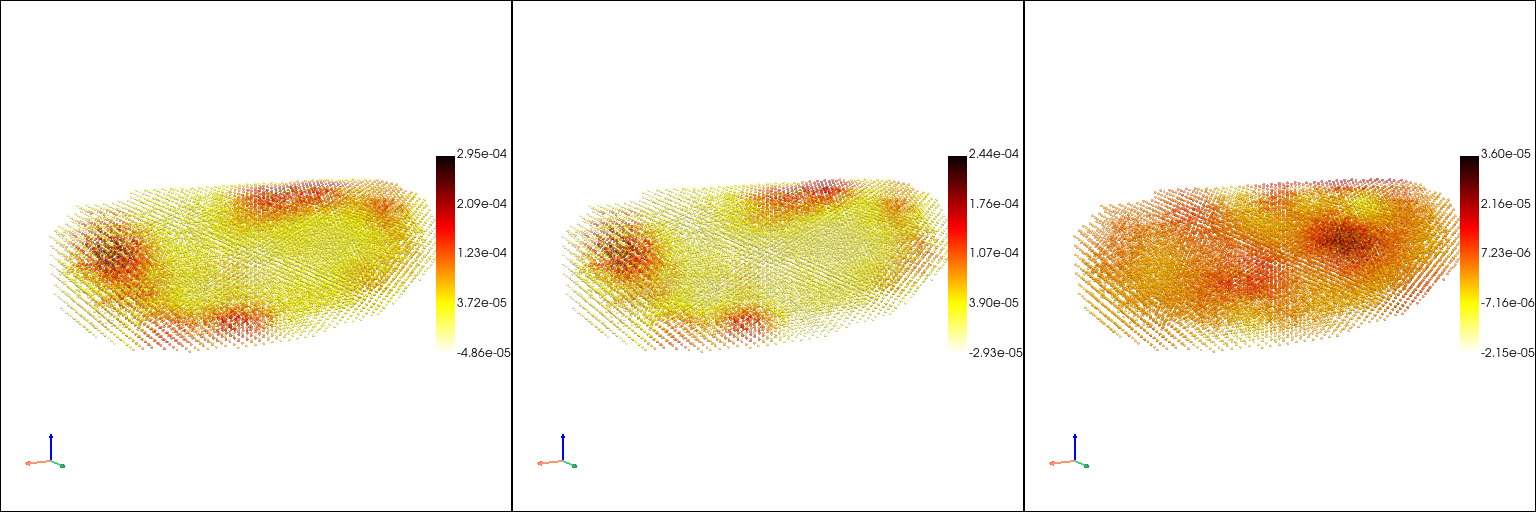

In [49]:
interpolated_svfc_pc, _ = st.tdr.construct_pc(adata=interpolated_svfc_adata.copy(), spatial_key="3d_align_spatial", groupby=genes[0])
_pc_index=interpolated_svfc_pc.point_data["obs_index"].tolist()
for gene_name in genes[1:]:
    _exp = interpolated_svfc_adata[_pc_index, gene_name].X.flatten()
    st.tdr.add_model_labels(model=interpolated_svfc_pc, labels=_exp, key_added=gene_name, where="point_data",inplace=True)

st.pl.three_d_multi_plot(
    model=interpolated_svfc_pc,
    key=genes,
    colormap="hot_r",
    opacity=0.5,
    model_style="points",
    jupyter="static",
    cpo=[cpo]
)

## Learn a continuous mapping from space to gene expression pattern with deep learning method

In [50]:
interpolated_deep_adata = st.tdr.deep_intepretation(source_adata=adata.copy(), spatial_key="3d_align_spatial", keys=genes, target_points=np.asarray(voxel.points))
interpolated_deep_adata

Iter [     100] Time [9.6025] regression loss [8.0899] autoencoder loss [nan]
Model saved in path: model_buffer/
Iter [     200] Time [14.8851] regression loss [8.7333] autoencoder loss [nan]
Model saved in path: model_buffer/
Iter [     300] Time [20.9004] regression loss [8.3215] autoencoder loss [nan]
Model saved in path: model_buffer/
Iter [     400] Time [29.4396] regression loss [8.4885] autoencoder loss [nan]
Model saved in path: model_buffer/
Iter [     500] Time [37.9800] regression loss [8.3785] autoencoder loss [nan]
Model saved in path: model_buffer/
Iter [     600] Time [46.5122] regression loss [8.7767] autoencoder loss [nan]
Model saved in path: model_buffer/
Iter [     700] Time [53.8855] regression loss [9.2763] autoencoder loss [nan]
Model saved in path: model_buffer/
Iter [     800] Time [60.2482] regression loss [9.0329] autoencoder loss [nan]
Model saved in path: model_buffer/
Iter [     900] Time [71.5819] regression loss [8.4838] autoencoder loss [nan]
Model save

AnnData object with n_obs × n_vars = 18780 × 3
    obsm: '3d_align_spatial'

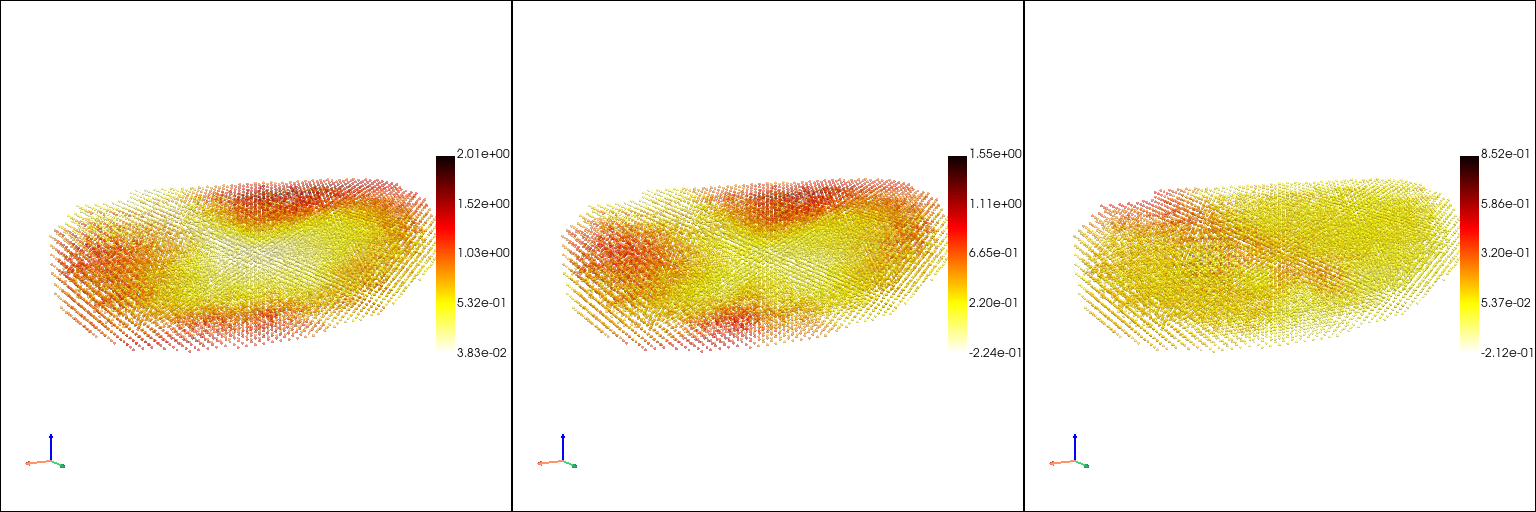

In [51]:
interpolated_deep_pc, _ = st.tdr.construct_pc(adata=interpolated_deep_adata.copy(), spatial_key="3d_align_spatial", groupby=genes[0])
_pc_index=interpolated_deep_pc.point_data["obs_index"].tolist()
for gene_name in genes[1:]:
    _exp = interpolated_deep_adata[_pc_index, gene_name].X.flatten()
    st.tdr.add_model_labels(model=interpolated_deep_pc, labels=_exp, key_added=gene_name, where="point_data",inplace=True)

st.pl.three_d_multi_plot(
    model=interpolated_deep_pc,
    key=genes,
    colormap="hot_r",
    opacity=0.5,
    model_style="points",
    jupyter="static",
    cpo=[cpo]
)